# Metal Project

Objectives of this project: 
- Scrape all bands from https://www.metal-archives.com/
- Plot what metal bands are where (e.g. # of metal bands per capita) (will come up with more ideas further along)
- Answer the question: Is is true that you can't walk through a forest in Europe without running into a folk metal band? 

# 0 Importing libraries and setting constants

In [1]:
# basics
import numpy as np
import pandas as pd
import time
import string

# visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# web scraping libraries
import requests
import selenium
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

# Geographic libraries
import geopandas
from geopandas import GeoDataFrame

# Linear regression modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Settings for web-scraping
options = Options()
options.headless = True

alpha = string.ascii_uppercase

# Constants and configuration settings for figures
BIG_FONT = 18
MED_FONT = 15
SMALL_FONT = 12

sns.set_style("darkgrid")
default_color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

# 1 Scraping data

First, grab data from metal-archives.com. Since this takes about 2 hours to complete, I am leaving this commented out so it's not accidentally run. Until the next update to get additional data (specific location, lyrical themes, label, ect.) we will only open the already-made csv file. 

In [2]:
# def scrape_bands(url): 
    
#     print(f"getting bands from: {url}")
#     def get_data(browser): 
#         elements = browser.find_elements_by_xpath('//*[contains(@id,"bandListAlpha")]//tr')
#         data = [[cell.text for cell in row.find_elements_by_xpath(".//*[self::td or self::th]")]
#                        for row in browser.find_elements_by_xpath('//*[contains(@id,"bandListAlpha")]//tr')]
#         return data

#     browser = webdriver.Firefox(options=options)
#     browser.get(url)
#     time.sleep(5)

#     data = get_data(browser)
#     df = pd.DataFrame(data)

#     page_num = 1
#     print(f"scrapping page {page_num}")
    
#     while True: 
#         button = browser.find_element_by_xpath('//*[@id="bandListAlpha_next"]')
#         if button.get_attribute("class") == "next paginate_button":

#             button.click()
#             time.sleep(5)
#             page_num += 1
#             print(f"scrapping page {page_num}")
#             data = get_data(browser)
#             df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
#         else: 
#             break
#     browser.quit()
    
#     return df

# pages = alpha + "\#" + "~"

# # Start timer. 
# start = time.time()

# frames = [scrape_bands("https://www.metal-archives.com/lists/" + page) for page in pages]
# bands = pd.concat(frames, ignore_index=True)

# print("done :)")
# end = time.time()
# print(f"time elapsed: {end-start}")
# bands.to_csv("bands_not_cleaned.csv")

bands = pd.read_csv("bands_not_cleaned.csv")
bands.head()

,Unnamed: 0,0,1,2,3
0,0,Band,Country,Genre,Status
1,1,Band,Country,Genre,Status
2,2,A // Solution,United States,Crust Punk/Thrash Metal,Split-up
3,3,A B I S M O,Brazil,Doom/Stoner Metal,Active
4,4,A Balance of Power,United States,Melodic Death Metal/Metalcore,Active


# 2 Data Preprocessing and exploration

# 2.1 Cleaning

Rename columns and drop 'Unnamed: 0'

In [3]:
bands = bands.rename(columns={'0': 'Band', '1': 'Country', '2': 'Genre', '3': 'Status'})
bands = bands.drop('Unnamed: 0', 1)
bands.head()

,Band,Country,Genre,Status
0,Band,Country,Genre,Status
1,Band,Country,Genre,Status
2,A // Solution,United States,Crust Punk/Thrash Metal,Split-up
3,A B I S M O,Brazil,Doom/Stoner Metal,Active
4,A Balance of Power,United States,Melodic Death Metal/Metalcore,Active


The header rows were included when scraping the data, hence the repeated column names at index 1 and 2. To fix this, drop all records that have "Band" and "Country" as the first two columns

In [4]:
bands = bands.drop(bands[(bands['Band']=='Band') & (bands['Country']=='Country')].index)
bands.head()

,Band,Country,Genre,Status
2,A // Solution,United States,Crust Punk/Thrash Metal,Split-up
3,A B I S M O,Brazil,Doom/Stoner Metal,Active
4,A Balance of Power,United States,Melodic Death Metal/Metalcore,Active
5,A Band of Orcs,United States,Death/Thrash Metal,Active
6,A Baptism by Fire,Canada,Progressive Power Metal,Active


# 2.2 Data Exploration

Now that the dataset is cleaned, let's explore some of its attributes

In [5]:
bands.describe()

,Band,Country,Genre,Status
count,168308,168308,168308,168308
unique,118966,153,9586,6
top,Abaddon,United States,Black Metal,Active
freq,102,35851,21223,93823


In [6]:
bands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168308 entries, 2 to 169003
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Band     168308 non-null  object
 1   Country  168308 non-null  object
 2   Genre    168308 non-null  object
 3   Status   168308 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


- There aren't any nulls
- The most popular band name appears to be 'Abaddon'
- Most metal bands are from the United States
- The most popular Genre is Black Metal

How many genres are listed? 

In [7]:
bands['Genre'].value_counts()

Black Metal                                                     21223
Death Metal                                                     13669
Heavy Metal                                                     10898
Thrash Metal                                                    10841
Melodic Death Metal                                              4398
                                                                ...  
Progressive/Experimental Rock/Folk                                  1
Ambient (early), Depressive Black Metal (later)                     1
Heavy/Black Metal, Rock                                             1
Atmospheric Drone/Funeral Doom Metal                                1
Power/Thrash Metal (early); Progressive Thrash Metal (later)        1
Name: Genre, Length: 9586, dtype: int64

There are over 9,000 different genres found- although it looks like this is because many bands can be classified as multiple genres. 

What about statuses? 

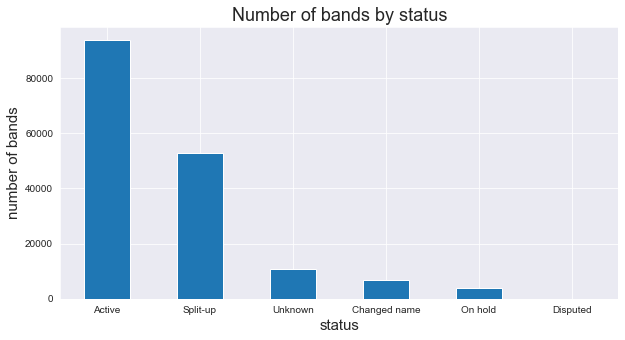

In [8]:
fig, ax = plt.subplots(figsize=[10, 5])
bands['Status'].value_counts().plot.bar()
ax.set_title("Number of bands by status", fontsize=BIG_FONT)
ax.set_xlabel("status", fontsize=MED_FONT)
ax.set_ylabel("number of bands", fontsize=MED_FONT);
plt.xticks(rotation=0);

In [9]:
def agg_bands(df=bands, genre_filter=None): 
    if genre_filter is not None: 
        df = df[df['Genre'].str.contains(genre_filter)]

    return pd.DataFrame({"Country": df['Country'].unique(), 
                         "num_bands": [len(df[df['Country'] == country]) 
                                       for country in df['Country'].unique()]
                        }).sort_values(by="num_bands", ascending=False)

In [10]:
num_bands = agg_bands(bands)
num_bands.head()

,Country,num_bands
0,United States,35851
4,Germany,13586
9,Italy,8261
1,Brazil,7958
3,United Kingdom,6764


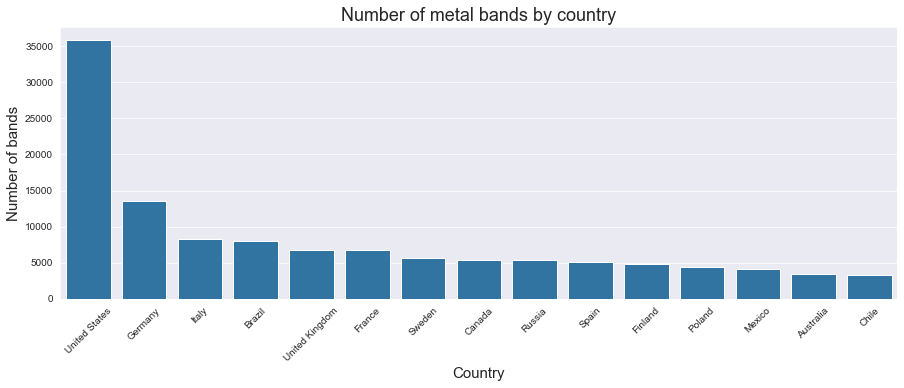

In [11]:
fig, ax = plt.subplots(figsize=[15, 5])
sns.barplot(x=num_bands['Country'].values[:15], y=num_bands['num_bands'].values[:15], color=default_color)
ax.set_title("Number of metal bands by country", fontsize=BIG_FONT)
ax.set_ylabel("Number of bands", fontsize=MED_FONT)
ax.set_xlabel("Country", fontsize=MED_FONT)
plt.xticks(rotation=45);

# 2.3 Geographic plots

Set up geopandas and try plotting the number of metal bands in each country. 

In [12]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Merge the bands dataset with this default world dataset to make a geographic plot of the number of metal bands in each country

In [13]:
bands_plot = GeoDataFrame(
    num_bands.merge(world, how="outer", left_on="Country", right_on="name").drop(["continent", "gdp_md_est"], 1)
)
bands_plot.head()

,Country,num_bands,pop_est,name,iso_a3,geometry
0,United States,35851.0,NaN,NaN,NaN,None
1,Germany,13586.0,80594017.0,Germany,DEU,"POLYGON ((14.11969 53.75703, 14.35332 53.24817..."
2,Italy,8261.0,62137802.0,Italy,ITA,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46..."
3,Brazil,7958.0,207353391.0,Brazil,BRA,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."
4,United Kingdom,6764.0,64769452.0,United Kingdom,GBR,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54..."


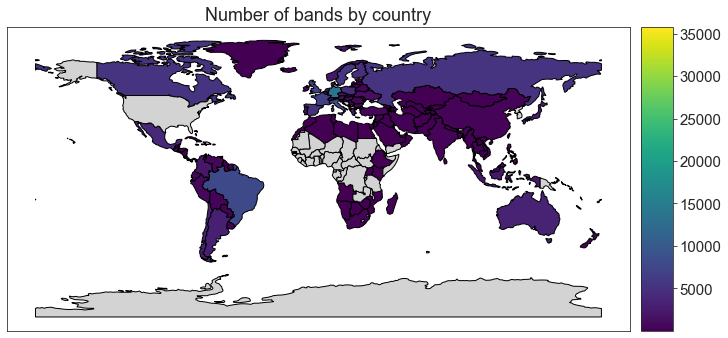

In [14]:
def plot_map(df_plot, col_plot='num_bands', title="Number of bands by country", figsize=[12, 10]): 
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        h = df_plot.plot(column=col_plot, 
                            ax=ax, 
                            legend=True, 
                            cax=cax, 
                            cmap="viridis", 
                            edgecolor='black', 
                            missing_kwds={'color': 'lightgrey'}
                        )
        cb_ax=fig.axes[1] 
        cb_ax.tick_params(labelsize=MED_FONT)
        h.set(xticklabels=[])
        h.set(yticklabels=[])
        ax.set_title(title, fontsize=BIG_FONT)
plot_map(bands_plot)

It appears we are missing some data!

As plotted above, the United States should be bright yellow.The most likely scenario is that there is a discrepancy between countries in the 'bands' dataset and countries in 'world'

In [15]:
diffs = [elem for elem in num_bands['Country'] if elem not in world['name'].values]
print(diffs)

['United States', 'International', 'Singapore', 'Korea, South', 'Unknown', 'Bosnia and Herzegovina', 'North Macedonia', 'Malta', 'Dominican Republic', 'Hong Kong', 'Faroe Islands', 'Reunion', 'Liechtenstein', 'Bahrain', 'Guernsey', 'Maldives', 'Åland Islands', 'San Marino', 'Gibraltar', 'Isle of Man', 'Jersey', 'Andorra', 'Guam', 'Monaco', 'Mauritius', 'Barbados', 'French Polynesia', 'Aruba', 'Saint Pierre and Miquelon', 'Svalbard', 'Curaçao', 'East Timor']


The bands dataset contains independent city-states, micro-countries, and words some countries differently (e.g. 'United States' instead of 'United States of America'). Rename these countries to either have the same name in the world dataset or use a nearby country. 

In [16]:
world_countries = world['name'].unique()
world_countries.sort()
world_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herz.', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Rep.', 'Chad', 'Chile',
       'China', 'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Denmark',
       'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador',
       'Eq. Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Is.',
       'Fiji', 'Finland', 'Fr. S. Antarctic Lands', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 

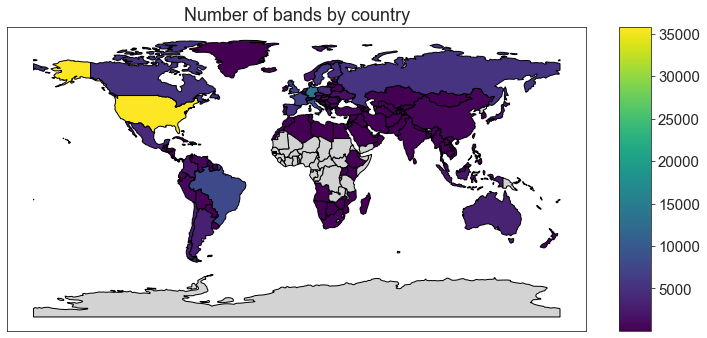

In [17]:
diffs_dict = {
    "United States"             : "United States of America", 
    "Korea, South"              : "South Korea",
    "Bosnia and Herzegovina"    : "Bosnia and Herz.",
    "North Macedonia"           : "Macedonia", 
    "Malta"                     : "Italy",
    "Dominican Republic"        : "Dominican Rep.", 
    "Hong Kong"                 : "China", 
    "Faroe Islands"             : "Denmark",
    "Reunion"                   : "France", 
    "Liechtenstein"             : "Germany", 
    "Bahrain"                   : "Saudi Arabia", 
    "Guernsey"                  : "United Kingdom", 
    "Maldives"                  : "India", 
    "Åland Islands"             : "Finland", 
    "San Marino"                : "Italy", 
    "Gibraltar"                 : "United Kingdom",
    "Isle of Man"               : "United Kingdom",
    "Jersey"                    : "United Kingdom",
    "Andorra"                   : "Spain", 
    "Guam"                      : "United States of America", 
    "Monaco"                    : "France", 
    "Mauritius"                 : "Madagascar", 
    "Barbados"                  : "United Kingdom",
    "French Polynesia"          : "France",
    "Aruba"                     : "Netherlands", 
    "Saint Pierre and Miquelon" : "France",
    "Svalbard"                  : "Norway", 
    "Curaçao"                   : "Denmark",
    "East Timor"                : "Timor-Leste"
}
bands = bands.replace(to_replace=diffs_dict)
bands = bands.drop(bands[bands['Country'].isin(["Unknown", "International"])].index)
num_bands = agg_bands(bands)
bands_plot = GeoDataFrame(
    num_bands.merge(world, how="outer", left_on="Country", right_on="name").drop(["continent", "gdp_md_est"], 1)
)
plot_map(bands_plot)

Next, control for population by getting bands per capita

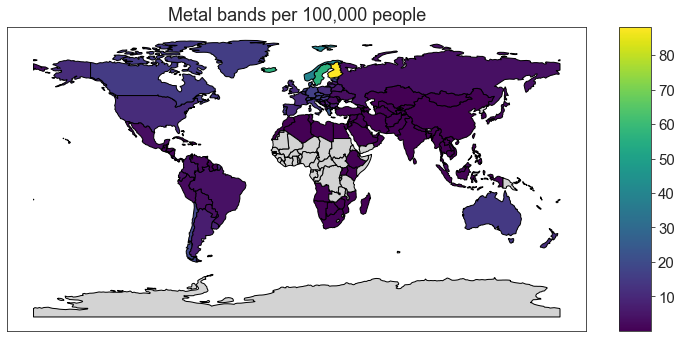

In [18]:
bands_plot['bands per capita'] = bands_plot.num_bands / (bands_plot.pop_est / 1e5)
plot_map(bands_plot, col_plot="bands per capita", title="Metal bands per 100,000 people")

# 3. Folk Metal Bands 

# 3.1 Get Bands Per Capita

Now, let's do a similar analysis with folk metal bands only. 

TODO: generate a complete list of genres by splitting each of these strings (use a set?)

Check which genres contain the word "Folk"

In [19]:
bands['Genre'][bands['Genre'].str.contains('Folk')].value_counts()

Folk Metal                                 420
Folk/Black Metal                           151
Black/Folk Metal                           141
Pagan/Folk Metal                            76
Melodic Death/Folk Metal                    55
                                          ... 
Folk/Speed Metal                             1
Acoustic/Folk                                1
Thrash/Death Metal with Folk influences      1
Progressive Folk/Ambient                     1
Thrash/Heavy/Middle Eastern Folk Metal       1
Name: Genre, Length: 651, dtype: int64

Notice that "Folk Metal" doesn't always appear as is, so we will filter to include any band that has the word "Folk" in the genre

In [20]:
num_folk_metal_bands = agg_bands(bands, genre_filter="Folk")
num_folk_metal_bands.sort_values(by="num_bands", ascending=False).head(10)

,Country,num_bands
3,Russia,215
11,United States of America,209
14,Germany,196
0,Italy,164
19,Spain,103
4,United Kingdom,99
9,France,98
10,Finland,93
15,Canada,90
35,Sweden,85


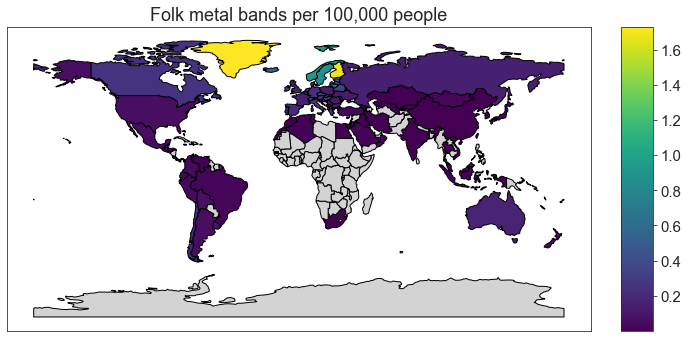

In [21]:
bands_plot = GeoDataFrame(
    num_folk_metal_bands.merge(world, 
                               how="outer", 
                               left_on="Country", 
                               right_on="name"
                               ).drop(["gdp_md_est"], 1)
    )

bands_plot['bands per capita'] = bands_plot.num_bands / (bands_plot.pop_est / 1e5)
plot_map(bands_plot, col_plot="bands per capita", title="Folk metal bands per 100,000 people")

In [22]:
bands_plot.sort_values(by="bands per capita", ascending=False).head()

,Country,num_bands,pop_est,continent,name,iso_a3,geometry,bands per capita
80,Greenland,1.0,57713.0,North America,Greenland,GRL,"POLYGON ((-46.76379 82.62796, -43.40644 83.225...",1.732712
7,Finland,93.0,5491218.0,Europe,Finland,FIN,"POLYGON ((28.59193 69.06478, 28.44594 68.36461...",1.693613
14,Norway,50.0,5320045.0,Europe,Norway,-99,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",0.939842
9,Sweden,85.0,9960487.0,Europe,Sweden,SWE,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",0.853372
32,Lithuania,19.0,2823859.0,Europe,Lithuania,LTU,"POLYGON ((26.49433 55.61511, 26.58828 55.16718...",0.672838


# 3.2 Merge with Forest Coverage Data
source: https://data.worldbank.org/indicator/AG.LND.FRST.ZS

In [23]:
forests = pd.read_csv("Forest data/API_AG.LND.FRST.ZS_DS2_en_csv_v2_1926709.csv", 
                      header=2)[["Country Name", "Country Code", "2016"]]

In [24]:
forests.head()

,Country Name,Country Code,2016
0,Aruba,ABW,2.333333
1,Afghanistan,AFG,2.067825
2,Angola,AGO,46.307210
3,Albania,ALB,28.121897
4,Andorra,AND,34.042553


In [25]:
# Generate X, Y pairs
folk_metal_bands = GeoDataFrame(
    world.merge(agg_bands(bands, genre_filter = "Folk"), how="outer", right_on="Country", left_on="name")
)
folk_metal_bands = folk_metal_bands.drop(["gdp_md_est", "Country"], 1)
folk_metal_bands['num_bands'] = folk_metal_bands['num_bands'].fillna(0)
folk_metal_bands['bands per capita'] = folk_metal_bands.num_bands / (folk_metal_bands.pop_est / 1e5)
folk_metal_bands.head()

,pop_est,continent,name,iso_a3,geometry,num_bands,bands per capita
0,920938.0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.0,0.000000
1,53950935.0,Africa,Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.0,0.000000
2,603253.0,Africa,W. Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0,0.000000
3,35623680.0,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",90.0,0.252641
4,326625791.0,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",209.0,0.063988


In [29]:
band_data = forests.merge(folk_metal_bands, how="outer", left_on="Country Name", 
                      right_on="name")
band_data = band_data.drop(band_data[band_data['name'].isna()].index)
band_data = band_data[["name", "2016", "bands per capita", "pop_est", "continent"]]
band_data = band_data.rename(columns = {"2016": "percent forest coverage"})
band_data = band_data[band_data['continent']=='Europe']
band_data = band_data.fillna(0)
band_data.head()

,name,percent forest coverage,bands per capita,pop_est,continent
3,Albania,28.121897,0.032809,3047987.0,Europe
12,Austria,46.905713,0.319839,8754413.0,Europe
15,Belgium,22.583885,0.287173,11491346.0,Europe
19,Bulgaria,35.373986,0.154897,7101510.0,Europe
23,Belarus,42.630106,0.366502,9549747.0,Europe


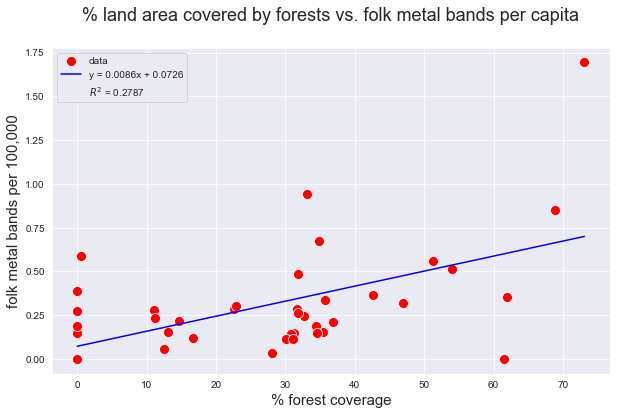

In [28]:
X = band_data.iloc[:, 1].values.reshape(-1, 1)
y = band_data.iloc[:, 2].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

r_square = round(regressor.score(X_train, y_train), 4)
r_label = f"$R^2$ = {r_square}"

b = round(regressor.intercept_[0], 4)
m = round(regressor.coef_[0][0], 4)

fig, ax = plt.subplots(figsize=[10, 6])


fit_label = f"y = {m}x + {b}"

sns.lineplot(x=X_train.reshape(1,-1)[0], y=regressor.predict(X_train).reshape(1,-1)[0], color='b', label=fit_label)
sns.scatterplot(x=band_data["percent forest coverage"].values, 
                y=band_data["bands per capita"].values, 
                ax=ax, 
                s=100, 
                color='r', 
                label='data')


plt.plot([], [], ' ', label=r_label)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0, 1]

plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order]
          )

ax.set_title("% land area covered by forests vs. folk metal bands per capita\n", fontsize=BIG_FONT)
ax.set_ylabel("folk metal bands per 100,000", fontsize=MED_FONT)
ax.set_xlabel("% forest coverage", fontsize=MED_FONT)
plt.savefig('metal.png')
plt.show()